In [707]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import pairwise_distances_argmin_min

from pycaret.datasets import get_data
from pycaret.regression import *

## Data Prepration

In [708]:
df = pd.read_csv("./CreditPrediction.csv")
df

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 19
0,768805383,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061,NaN
1,818770008,49.0,F,5,Graduate,NaN,Less than $40K,Blue,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105,NaN
2,713982108,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000,NaN
3,769911858,40.0,F,4,High School,NaN,Less than $40K,Blue,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760,NaN
4,709106358,40.0,M,3,Uneducated,Married,$60K - $80K,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10162,718673358,35.0,M,3,Doctorate,NaN,$80K - $120K,Blue,30.0,5.0,3,4,13590.0,1528,0.728,2137,52,0.486,0.112,NaN
10163,715207458,46.0,F,1,Unknown,Single,Less than $40K,Blue,39.0,2.0,2,1,2029.0,1074,0.514,4802,90,0.800,0.529,NaN
10164,803665983,52.0,M,0,Unknown,NaN,$60K - $80K,Blue,46.0,3.0,2,4,2742.0,2184,0.592,3829,72,0.532,0.796,NaN
10165,713183508,39.0,F,1,High School,NaN,Unknown,NaN,36.0,1.0,3,2,2751.0,1158,0.821,4861,82,0.822,0.421,NaN


### Handling N/A

In [709]:
df = df.replace('Unknown', np.nan)
df = df.drop(columns=["CLIENTNUM", "Unnamed: 19"], errors='ignore')

print(f"Percentage of data remaining after calling dropna(): %{100 * df.dropna().shape[0] / df.shape[0]}")

# Counting NaN values in all columns
nan_count = df.isna().sum()

print(nan_count)

Percentage of data remaining after calling dropna(): %43.965771614045444
Customer_Age                   0
Gender                       199
Dependent_count                0
Education_Level             1522
Marital_Status              2571
Income_Category             1122
Card_Category               1924
Months_on_book               223
Total_Relationship_Count      20
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64


In [710]:
# df = df.fillna({
#     "Gender": df["Gender"].mode()[0],
#     "Education_Level": df["Education_Level"].mode()[0],
#     "Marital_Status": df["Marital_Status"].mode()[0],
#     "Income_Category": df["Income_Category"].mode()[0],
#     "Card_Category": df["Card_Category"].mode()[0],
#     "Months_on_book": df["Months_on_book"].mean(),
#     "Total_Relationship_Count": df["Total_Relationship_Count"].mean(),
# })

### Handling Duplicates

In [711]:
print("Number of duplicates to remove:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)

Number of duplicates to remove: 35


## Data Analysis

In [712]:
# print(df.head())
# print(df.info())
# print(df.describe())

In [713]:
# Function to handle outliers based on IQR method
def handle_outliers(df, column, method='remove'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR

    if method == 'remove':
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    elif method == 'nan':
        df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = np.nan
        return df
    else:
        raise ValueError("Method must be 'remove' or 'nan'")

In [714]:
# Apply the function to each column
df_no_outliers = df.copy()
for column in ["Customer_Age", "Months_on_book", "Total_Relationship_Count", "Dependent_count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Amt_Chng_Q4_Q1", "Total_Trans_Amt", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1", "Avg_Utilization_Ratio"]:
    df_no_outliers = handle_outliers(df_no_outliers, column, method='remove')
    print(f"Removed {len(df[column]) - len(df_no_outliers[column])} rows for column {column}")
df = df_no_outliers

Removed 17 rows for column Customer_Age
Removed 236 rows for column Months_on_book
Removed 255 rows for column Total_Relationship_Count
Removed 255 rows for column Dependent_count
Removed 374 rows for column Months_Inactive_12_mon
Removed 427 rows for column Contacts_Count_12_mon
Removed 427 rows for column Total_Revolving_Bal
Removed 575 rows for column Total_Amt_Chng_Q4_Q1
Removed 1293 rows for column Total_Trans_Amt
Removed 1293 rows for column Total_Trans_Ct
Removed 1376 rows for column Total_Ct_Chng_Q4_Q1
Removed 1376 rows for column Avg_Utilization_Ratio


### Income Categories

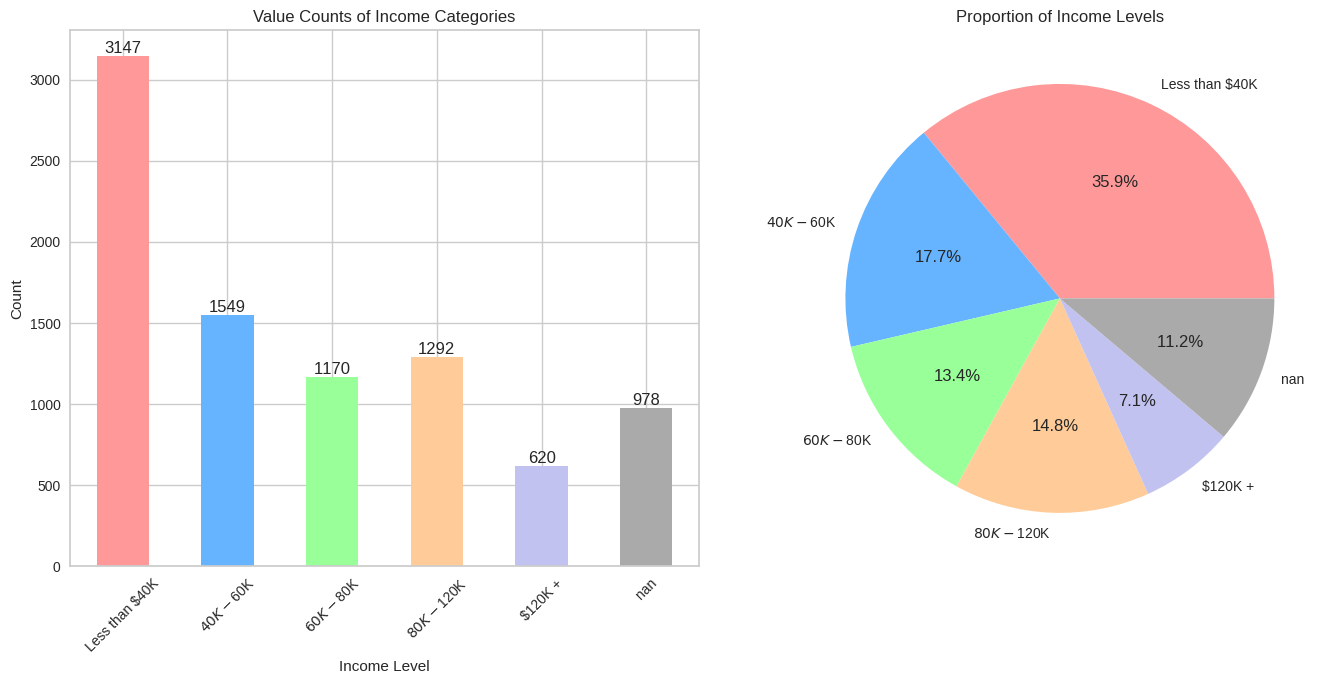

In [715]:
income_cat_mapping = {
    'Less than $40K': 1,
    '$40K - $60K': 2,
    '$60K - $80K': 3,
    '$80K - $120K': 4,
    '$120K +': 5,
    np.nan: np.nan,
}

value_counts = df['Income_Category'].value_counts(dropna=False)
labels = income_cat_mapping.keys()
# Sorting the values
value_counts = value_counts.reindex(labels)

# Define a color palette
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#aaaaaa']

# Plotting the bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
value_counts.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Value Counts of Income Categories')
axes[0].set_xlabel('Income Level')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(labels, rotation=45)
# Annotate the bar chart with counts
for i, count in enumerate(value_counts):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

# Plotting the pie chart
value_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=colors)
axes[1].set_title('Proportion of Income Levels')
axes[1].set_ylabel('')  # Hide the y-label for the pie chart

plt.tight_layout()
plt.show()

In [716]:
df['Income_Category'].value_counts()
income_cat_mapping = {
    'Less than $40K': 1,
    '$40K - $60K': 2,
    '$60K - $80K': 3,
    '$80K - $120K': 4,
    '$120K +': 5,
    np.nan: 6
}
df['Income_Category_Enc'] = df['Income_Category'].map(income_cat_mapping).astype(int)
df = df.drop(columns=['Income_Category'])

### Card Types

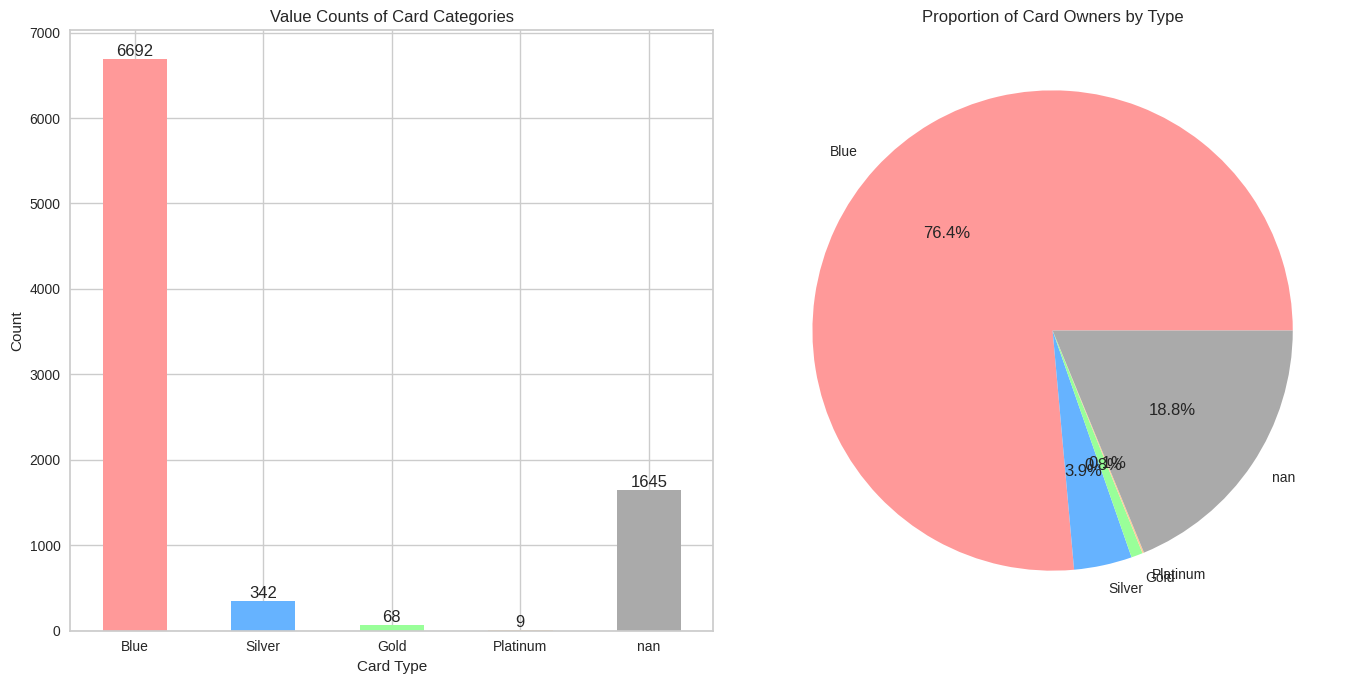

In [717]:
card_cat_mapping = {
    'Blue': 1,
    'Silver': 2,
    'Gold': 3,
    'Platinum': 4,
    np.nan: np.nan
}

value_counts = df['Card_Category'].value_counts(dropna=False)
labels = card_cat_mapping.keys()
# Sorting the values
value_counts = value_counts.reindex(labels)

# Define a color palette
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#aaaaaa']

# Plotting the bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
value_counts.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Value Counts of Card Categories')
axes[0].set_xlabel('Card Type')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(labels, rotation=0)
# Annotate the bar chart with counts
for i, count in enumerate(value_counts):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

# Plotting the pie chart
value_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=colors)
axes[1].set_title('Proportion of Card Owners by Type')
axes[1].set_ylabel('')  # Hide the y-label for the pie chart

plt.tight_layout()
plt.show()

In [718]:
df['Card_Category_Enc'] = df['Card_Category'].map(card_cat_mapping)
df = df.drop(columns=["Card_Category"])

### Genders

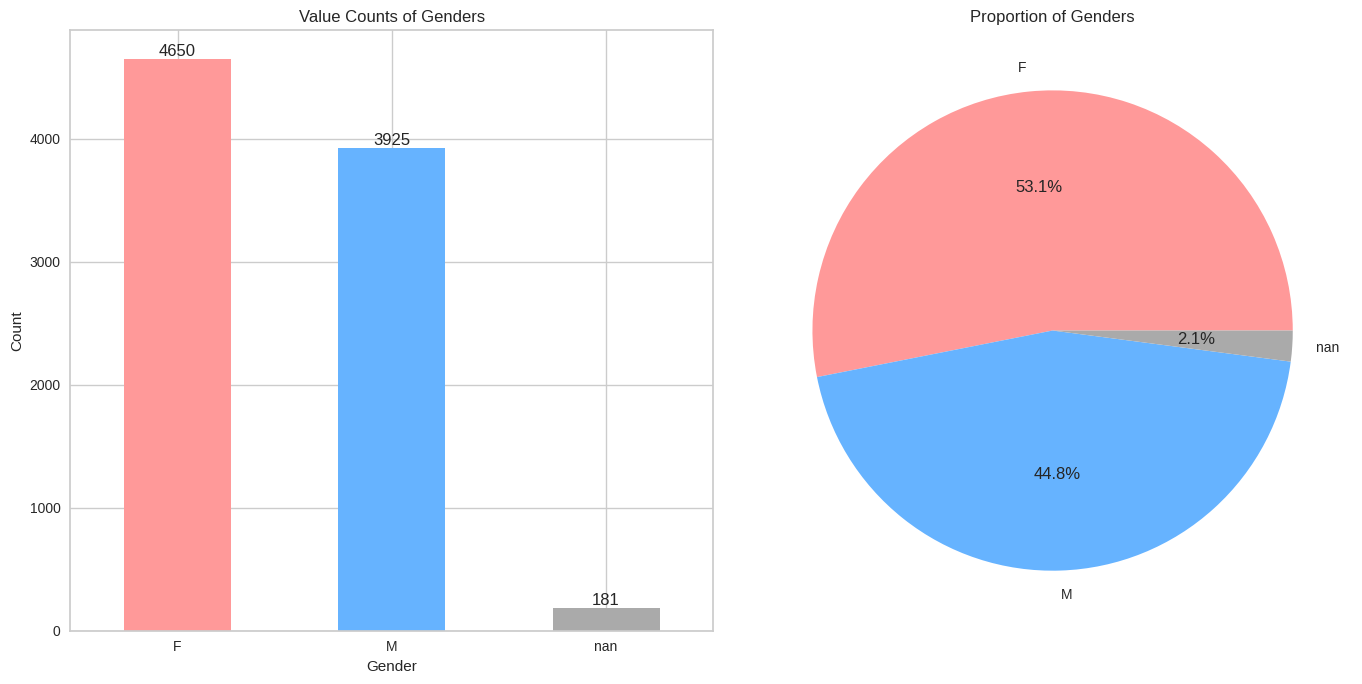

In [719]:
value_counts = df['Gender'].value_counts(dropna=False)

# Define a color palette
colors = ['#ff9999','#66b3ff','#aaaaaa']

# Plotting the bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
value_counts.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Value Counts of Genders')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', labelrotation=0)
# Annotate the bar chart with counts
for i, count in enumerate(value_counts):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

# Plotting the pie chart
value_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=colors)
axes[1].set_title('Proportion of Genders')
axes[1].set_ylabel('')  # Hide the y-label for the pie chart

plt.tight_layout()
plt.show()

In [720]:
df['Gender'] = df['Gender'].replace({'M': 1, 'F': 0})

### Marital Status

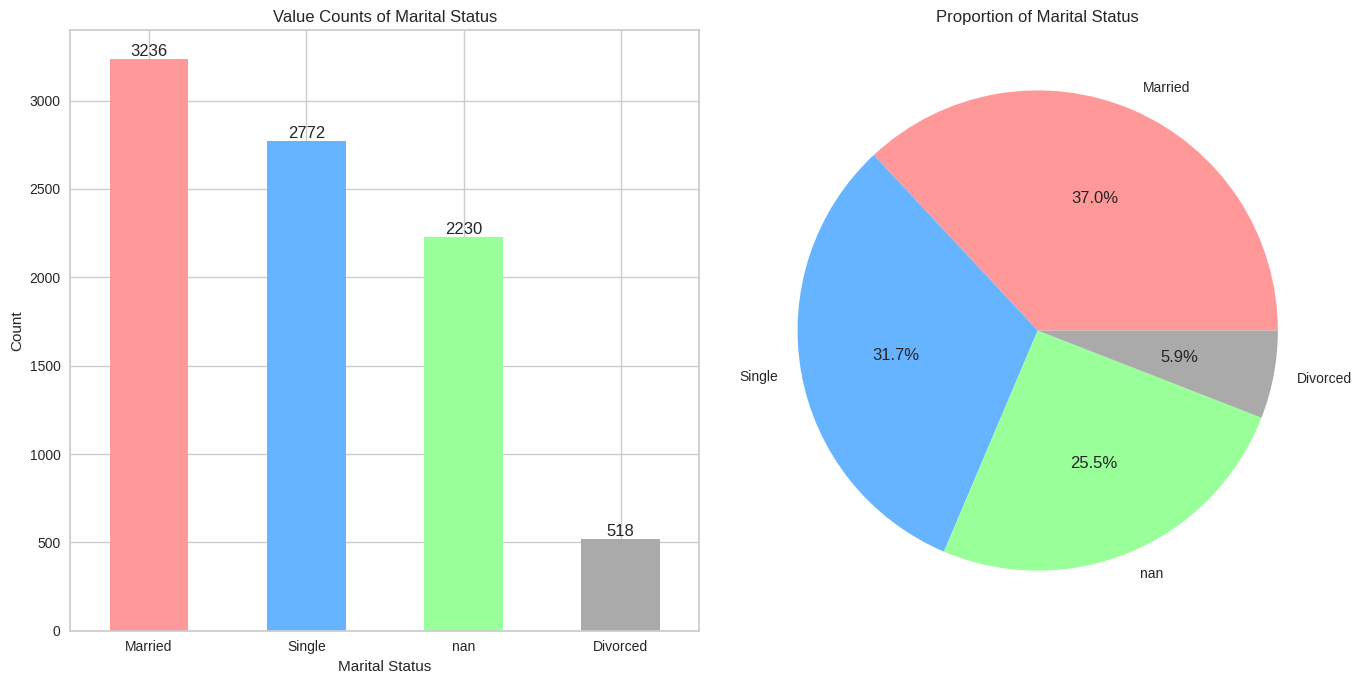

In [721]:
value_counts = df['Marital_Status'].value_counts(dropna=False)

# Define a color palette
colors = ['#ff9999','#66b3ff','#99ff99','#aaaaaa']

# Plotting the bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
value_counts.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Value Counts of Marital Status')
axes[0].set_xlabel('Marital Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', labelrotation=0)
# Annotate the bar chart with counts
for i, count in enumerate(value_counts):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

# Plotting the pie chart
value_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=colors)
axes[1].set_title('Proportion of Marital Status')
axes[1].set_ylabel('')  # Hide the y-label for the pie chart

plt.tight_layout()
plt.show()

In [722]:
df = pd.get_dummies(df, columns=['Marital_Status'], drop_first=True, dtype=int, dummy_na=True)

In [723]:
df

,Customer_Age,Gender,Dependent_count,Education_Level,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Income_Category_Enc,Card_Category_Enc,Marital_Status_Married,Marital_Status_Single,Marital_Status_nan
5,44.0,1.0,2,Graduate,36.0,3.0,1,2,4010.0,1247,1.376,1088,24,0.846,0.311,2,1.0,1,0,0
10,42.0,1.0,5,Uneducated,31.0,5.0,3,2,6748.0,1467,0.831,1201,42,0.680,0.217,5,1.0,0,0,1
14,57.0,0.0,2,Graduate,48.0,5.0,2,2,2436.0,680,1.190,1570,29,0.611,0.279,1,1.0,1,0,0
19,45.0,0.0,2,Graduate,37.0,6.0,1,2,14470.0,1157,0.966,1207,21,0.909,0.080,6,1.0,1,0,0
20,47.0,1.0,1,Doctorate,42.0,5.0,2,0,20979.0,1800,0.906,1178,27,0.929,0.086,3,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10127,37.0,0.0,3,High School,18.0,4.0,1,3,2179.0,0,0.725,2568,48,0.297,0.000,6,NaN,0,0,1
10128,53.0,1.0,2,College,33.0,3.0,3,1,4065.0,2180,0.321,1271,36,0.200,0.536,2,1.0,0,0,1
10129,56.0,0.0,2,Uneducated,43.0,6.0,3,2,3068.0,1765,0.853,4611,73,0.698,0.575,6,1.0,1,0,0
10130,37.0,0.0,2,Graduate,32.0,6.0,1,3,1438.3,0,0.707,4733,89,0.816,0.000,1,NaN,1,0,0


### Education Level

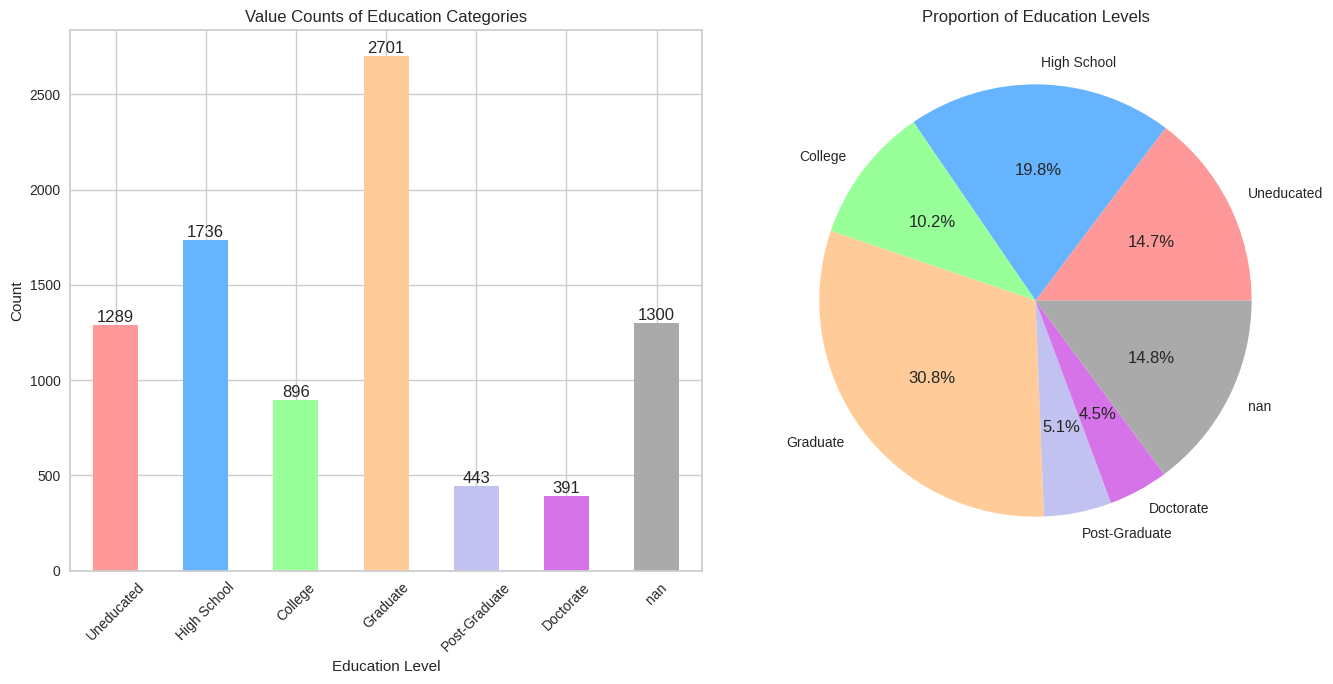

In [724]:
edu_mapping = {
    'Uneducated': 1,
    'High School': 2,
    'College': 3,
    'Graduate': 4,
    'Post-Graduate': 5,
    'Doctorate': 6,
    np.nan: np.nan
}

value_counts = df['Education_Level'].value_counts(dropna=False)
labels = edu_mapping.keys()
# Sorting the values
value_counts = value_counts.reindex(labels)

# Define a color palette
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#d773e9','#aaaaaa']

# Plotting the bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
value_counts.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Value Counts of Education Categories')
axes[0].set_xlabel('Education Level')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(labels, rotation=45)
# Annotate the bar chart with counts
for i, count in enumerate(value_counts):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

# Plotting the pie chart
value_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=colors)
axes[1].set_title('Proportion of Education Levels')
axes[1].set_ylabel('')  # Hide the y-label for the pie chart

plt.tight_layout()
plt.show()

In [725]:
df['Education_Level_Enc'] = df['Education_Level'].map(edu_mapping)
df = df.drop(columns=['Education_Level'])

### Customers Ages

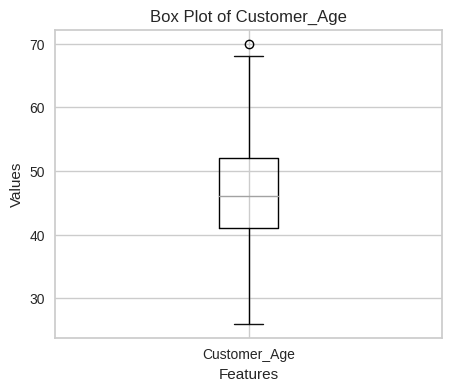

In [726]:
# for col in ["Customer_Age", "Months_on_book", "Total_Relationship_Count", "Dependent_count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal", "Total_Amt_Chng_Q4_Q1", "Total_Trans_Amt", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1", "Avg_Utilization_Ratio"]:
plt.figure(figsize=(5, 4))
df.boxplot(column=["Customer_Age"])
plt.title('Box Plot of Customer_Age')
plt.xlabel('Features')
plt.ylabel('Values')
plt.grid(True)
plt.show()

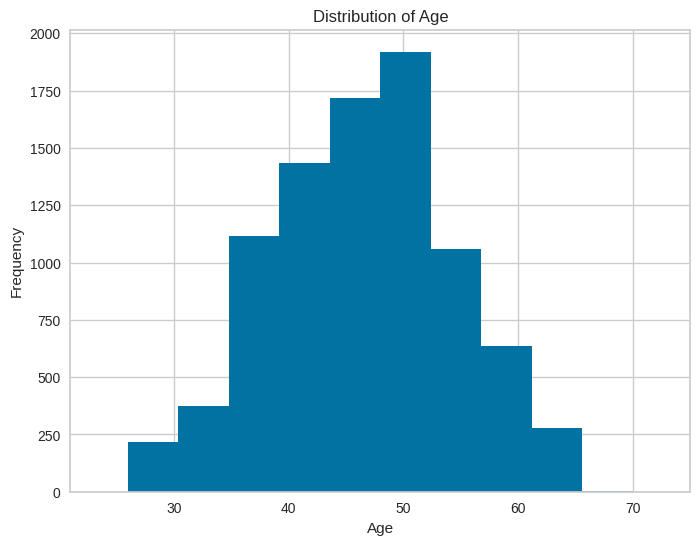

In [727]:
# Bar Chart
plt.figure(figsize=(8, 6))
plt.hist(df["Customer_Age"])
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
# plt.grid(True)
plt.xlim(min(df["Customer_Age"]) - 5, max(df["Customer_Age"]) + 5)
plt.show()


In [728]:
print("min:", min(df["Months_on_book"]), "max:", max(df["Months_on_book"]))

min: 13.0 max: 56.0


In [729]:
print("min:", min(df["Total_Relationship_Count"]), "max:", max(df["Total_Relationship_Count"]))

min: 1.0 max: 6.0


In [730]:
df.isna().sum()

Customer_Age                   0
Gender                       181
Dependent_count                0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
Income_Category_Enc            0
Card_Category_Enc           1645
Marital_Status_Married         0
Marital_Status_Single          0
Marital_Status_nan             0
Education_Level_Enc         1300
dtype: int64

In [731]:
print("Before imputation:\n", df.isna().sum())

# Initialize the KNN Imputer
imputer = KNNImputer(n_neighbors=3)

# Apply the imputer to the DataFrame
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

df_imputed

Before imputation:
 Customer_Age                   0
Gender                       181
Dependent_count                0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
Income_Category_Enc            0
Card_Category_Enc           1645
Marital_Status_Married         0
Marital_Status_Single          0
Marital_Status_nan             0
Education_Level_Enc         1300
dtype: int64


,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Income_Category_Enc,Card_Category_Enc,Marital_Status_Married,Marital_Status_Single,Marital_Status_nan,Education_Level_Enc
0,44.0,1.0,2.0,36.0,3.0,1.0,2.0,4010.0,1247.0,1.376,1088.0,24.0,0.846,0.311,2.0,1.0,1.0,0.0,0.0,4.0
1,42.0,1.0,5.0,31.0,5.0,3.0,2.0,6748.0,1467.0,0.831,1201.0,42.0,0.680,0.217,5.0,1.0,0.0,0.0,1.0,1.0
2,57.0,0.0,2.0,48.0,5.0,2.0,2.0,2436.0,680.0,1.190,1570.0,29.0,0.611,0.279,1.0,1.0,1.0,0.0,0.0,4.0
3,45.0,0.0,2.0,37.0,6.0,1.0,2.0,14470.0,1157.0,0.966,1207.0,21.0,0.909,0.080,6.0,1.0,1.0,0.0,0.0,4.0
4,47.0,1.0,1.0,42.0,5.0,2.0,0.0,20979.0,1800.0,0.906,1178.0,27.0,0.929,0.086,3.0,1.0,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8751,37.0,0.0,3.0,18.0,4.0,1.0,3.0,2179.0,0.0,0.725,2568.0,48.0,0.297,0.000,6.0,1.0,0.0,0.0,1.0,2.0
8752,53.0,1.0,2.0,33.0,3.0,3.0,1.0,4065.0,2180.0,0.321,1271.0,36.0,0.200,0.536,2.0,1.0,0.0,0.0,1.0,3.0
8753,56.0,0.0,2.0,43.0,6.0,3.0,2.0,3068.0,1765.0,0.853,4611.0,73.0,0.698,0.575,6.0,1.0,1.0,0.0,0.0,1.0
8754,37.0,0.0,2.0,32.0,6.0,1.0,3.0,1438.3,0.0,0.707,4733.0,89.0,0.816,0.000,1.0,1.0,1.0,0.0,0.0,4.0


In [743]:
s = setup(df_imputed, target="Credit_Limit", session_id=123)
bset = compare_models()

,Description,Value
0,Session id,123
1,Target,Credit_Limit
2,Target type,Regression
3,Original data shape,"(8756, 20)"
4,Transformed data shape,"(8756, 20)"
5,Transformed train set shape,"(6129, 20)"
6,Transformed test set shape,"(2627, 20)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1339.9883,9759522.5768,3112.5919,0.8777,0.3905,0.2777,1.4510
et,Extra Trees Regressor,1279.1615,10156097.5354,3175.7835,0.8733,0.3966,0.2677,2.8300
rf,Random Forest Regressor,1323.9636,10225121.1328,3187.9812,0.8723,0.3970,0.2770,4.5650
gbr,Gradient Boosting Regressor,1664.8710,10568959.9039,3242.6551,0.8680,0.4161,0.3287,1.7410
xgboost,Extreme Gradient Boosting,1540.8091,10934401.9500,3293.7407,0.8629,0.4700,0.3202,0.2580
ada,AdaBoost Regressor,2958.7062,19725607.5213,4435.5560,0.7535,0.5878,0.6579,0.1670
dt,Decision Tree Regressor,1805.2356,20457106.0361,4512.4810,0.7438,0.5193,0.3365,0.0810
llar,Lasso Least Angle Regression,4061.1377,30804103.6000,5543.3870,0.6165,0.8933,0.8908,0.0310
ridge,Ridge Regression,4060.4875,30805377.6000,5543.5041,0.6165,0.8894,0.8902,0.0270
lasso,Lasso Regression,4061.1381,30804106.4000,5543.3873,0.6165,0.8933,0.8908,0.0300


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [733]:
X = df_imputed.drop(columns=["Credit_Limit"])
y = df_imputed["Credit_Limit"]

In [734]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [735]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [736]:
# Initialize the model
model = RandomForestRegressor()

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [737]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 10274570.39934987
R-squared: 0.870661325954436


In [738]:
# Step 1: Cluster the training data
n_clusters = 3  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_clusters = kmeans.fit_predict(X_train)

In [739]:
# Step 2: Train a Random Forest Regressor on each cluster
forest_models = []
for cluster in range(n_clusters):
    cluster_indices = np.where(train_clusters == cluster)[0]
    cluster_X = X_train[cluster_indices]
    cluster_y = y_train.iloc[cluster_indices]

    model = RandomForestRegressor(random_state=42)
    model.fit(cluster_X, cluster_y)
    forest_models.append(model)

In [740]:
# Predicting on test data
closest_cluster_indices, _ = pairwise_distances_argmin_min(X_test, kmeans.cluster_centers_)
predictions = np.zeros(len(X_test))

for i, cluster_index in enumerate(closest_cluster_indices):
    predictions[i] = forest_models[kmeans.labels_[cluster_index]].predict([X_test[i]])

In [741]:
# Calculate MSE and R2 score
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 11972238.599267434
R-squared (R2) Score: 0.8492906850991695


In [742]:
kmeans.cluster_centers_

array([[-2.60581868e-02,  1.27002378e-03,  4.29382528e-02,
        -5.30971112e-02,  1.48325073e-02, -3.44072954e-02,
         2.95260176e-03,  1.42960234e-02,  7.01058972e-03,
         6.61656958e-02,  4.26513247e-02,  3.76544453e-03,
        -2.89291340e-02,  1.68923284e-02,  1.33758207e-02,
        -7.66243393e-01, -6.75376233e-01,  1.70734775e+00,
        -8.56826541e-03],
       [-3.38231701e-02, -3.41138034e-02, -4.93338133e-02,
        -2.02813439e-02, -4.38450223e-02,  2.53843167e-02,
         4.53628634e-03, -7.04375350e-02, -1.65136565e-02,
         1.52231262e-01,  2.05088403e-01,  2.49085585e-02,
        -3.71064337e-02, -2.71540730e-02,  5.86371897e-02,
        -7.66243393e-01,  1.25144052e+00, -5.85703763e-01,
        -1.43865710e-02],
       [ 4.69760793e-02,  2.95207662e-02,  1.60499918e-02,
         5.24570403e-02,  2.93855704e-02, -2.76755846e-04,
        -5.94883606e-03,  5.33871603e-02,  1.01445948e-02,
        -1.78296442e-01, -2.10070742e-01, -2.45966998e-02,
    